In [1]:
from environments import ZeroDCleanupEnv
from agents import CentralizedQAgent
import numpy as np
from collections import defaultdict
import torch
import sys
from tqdm import tqdm

2023-11-19 23:06:57,053	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
np.set_printoptions(threshold=sys.maxsize)

cpu


In [3]:
num_agents = 10
agent_ids = [str(i) for i in range(num_agents)]
reward_multiplier = 10

In [4]:
pp = False
verbose = False
verbose_episode = 1999

In [5]:
num_episodes = 10
max_steps_per_episode = 1000
state_dim = 4
action_dim = 2

In [6]:
thresholdDepletion = 0.4
thresholdRestoration = 0.0
wasteSpawnProbability = 0.5
appleRespawnProbability = 0.05
dirt_multiplier = 10

area = 150

In [7]:
env = ZeroDCleanupEnv(agent_ids, 
                      num_agents=num_agents, 
                      area=area, 
                      thresholdDepletion=thresholdDepletion,
                      thresholdRestoration=thresholdRestoration,
                      wasteSpawnProbability=wasteSpawnProbability,
                      appleRespawnProbability=appleRespawnProbability,
                      dirt_multiplier=dirt_multiplier)

agentCoordinator = CentralizedQAgent(device=device,
                                     num_agents=num_agents,
                                     action_size=action_dim,
                                     state_dim=state_dim,
                                     verbose=False)

In [8]:
ending_ep_rewards = []
weight_graph = defaultdict(list)

In [9]:
import uuid
import os

if not os.path.exists("results"):
    os.mkdir("results")

test_id = uuid.uuid4()
os.mkdir("results/q_simple_" + str(test_id))
f = open("results/q_simple_" + str(test_id) + "/logs.txt", "x")

In [10]:
for episode in range(num_episodes):
    print(f"========= Episode {episode} =========")
    f.write(f"========= Episode {episode} =========\n")

    states, info = env.reset()
    states = np.concatenate(list(states.values()), axis=0)

    print(f"info: {info}")
    f.write(f"info: {info}\n")

    for step in tqdm(range(max_steps_per_episode)):
        actions_list = agentCoordinator.act(states)[0]
        actions = {agent_id: actions_list[i] for i, agent_id in enumerate(agent_ids)}
        next_states, rewards, dones, _, info = env.step(actions)
        next_states = np.concatenate(list(next_states.values()), axis=0)
        reward = sum(rewards.values())
        #reward_graph.append(reward)
        agentCoordinator.step(states, actions_list, reward, next_states)

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")
            f.write(f"========= Step {step} =========\n")
            f.write(f"info: {info}\n")

        states = next_states

        if dones["__all__"]:
            break 

    print(f"ending info: {info}")
    #print(f"reward graph: {reward_graph}")
    print(f"========= End of Episode {episode} =========")
    
    f.write(f"ending info: {info}\n")
    #f.write(f"reward graph: {reward_graph}\n")
    f.write(f"========= End of Episode {episode} =========\n")

    ending_reward = info["total_apple_consumed"]

    ending_ep_rewards.append(ending_reward)

torch.save(agentCoordinator.q_network.state_dict(), "results/q_simple_" + str(test_id) + "/q_network.pt")

        

========= Episode 0 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': array([0]), 'dirt': array([78]), 'picker': array([0]), 'cleaner': array([0])}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|█████████▉| 999/1000 [00:01<00:00, 615.56it/s] 


ending info: {'total_apple_consumed': 4682, 'step_apple_consumed': 8, 'apple': array([144]), 'dirt': array([16]), 'picker': array([0]), 'cleaner': array([0])}
========= End of Episode 0 =========
========= Episode 1 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': array([0]), 'dirt': array([78]), 'picker': array([0]), 'cleaner': array([0])}


100%|█████████▉| 999/1000 [00:01<00:00, 595.62it/s]


ending info: {'total_apple_consumed': 4895, 'step_apple_consumed': 4, 'apple': array([149]), 'dirt': array([13]), 'picker': array([0]), 'cleaner': array([0])}
========= End of Episode 1 =========
========= Episode 2 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': array([0]), 'dirt': array([78]), 'picker': array([0]), 'cleaner': array([0])}


100%|█████████▉| 999/1000 [00:01<00:00, 754.88it/s]


ending info: {'total_apple_consumed': 4983, 'step_apple_consumed': 3, 'apple': array([145]), 'dirt': array([13]), 'picker': array([0]), 'cleaner': array([0])}
========= End of Episode 2 =========
========= Episode 3 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': array([0]), 'dirt': array([78]), 'picker': array([0]), 'cleaner': array([0])}


100%|█████████▉| 999/1000 [00:01<00:00, 765.02it/s]


ending info: {'total_apple_consumed': 5075, 'step_apple_consumed': 2, 'apple': array([131]), 'dirt': array([17]), 'picker': array([0]), 'cleaner': array([0])}
========= End of Episode 3 =========
========= Episode 4 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': array([0]), 'dirt': array([78]), 'picker': array([0]), 'cleaner': array([0])}


100%|█████████▉| 999/1000 [00:01<00:00, 701.25it/s]


ending info: {'total_apple_consumed': 5024, 'step_apple_consumed': 5, 'apple': array([146]), 'dirt': array([16]), 'picker': array([0]), 'cleaner': array([0])}
========= End of Episode 4 =========
========= Episode 5 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': array([0]), 'dirt': array([78]), 'picker': array([0]), 'cleaner': array([0])}


100%|█████████▉| 999/1000 [00:01<00:00, 684.57it/s]


ending info: {'total_apple_consumed': 5009, 'step_apple_consumed': 3, 'apple': array([149]), 'dirt': array([17]), 'picker': array([0]), 'cleaner': array([0])}
========= End of Episode 5 =========
========= Episode 6 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': array([0]), 'dirt': array([78]), 'picker': array([0]), 'cleaner': array([0])}


100%|█████████▉| 999/1000 [00:01<00:00, 739.19it/s]


ending info: {'total_apple_consumed': 5159, 'step_apple_consumed': 6, 'apple': array([148]), 'dirt': array([20]), 'picker': array([0]), 'cleaner': array([0])}
========= End of Episode 6 =========
========= Episode 7 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': array([0]), 'dirt': array([78]), 'picker': array([0]), 'cleaner': array([0])}


100%|█████████▉| 999/1000 [00:01<00:00, 765.53it/s]


ending info: {'total_apple_consumed': 5044, 'step_apple_consumed': 2, 'apple': array([150]), 'dirt': array([18]), 'picker': array([0]), 'cleaner': array([0])}
========= End of Episode 7 =========
========= Episode 8 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': array([0]), 'dirt': array([78]), 'picker': array([0]), 'cleaner': array([0])}


100%|█████████▉| 999/1000 [00:01<00:00, 760.00it/s]


ending info: {'total_apple_consumed': 5162, 'step_apple_consumed': 4, 'apple': array([146]), 'dirt': array([16]), 'picker': array([0]), 'cleaner': array([0])}
========= End of Episode 8 =========
========= Episode 9 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': array([0]), 'dirt': array([78]), 'picker': array([0]), 'cleaner': array([0])}


100%|█████████▉| 999/1000 [00:01<00:00, 739.24it/s]

ending info: {'total_apple_consumed': 4909, 'step_apple_consumed': 6, 'apple': array([150]), 'dirt': array([19]), 'picker': array([0]), 'cleaner': array([0])}
========= End of Episode 9 =========


In [11]:
print("========= Testing =========")
f.write("========= Testing =========\n")

states, info = env.reset()
states = np.concatenate(list(states.values()), axis=0)

print(f"info: {info}")
f.write(f"info: {info}\n")

for step in tqdm(range(max_steps_per_episode)):
    actions_list = agentCoordinator.act(states)[0]
    actions = {agent_id: actions_list[i] for i, agent_id in enumerate(agent_ids)}
    next_states, rewards, dones, _, info = env.step(actions)
    next_states = np.concatenate(list(next_states.values()), axis=0)
    reward = sum(rewards.values())
    #reward_graph.append(reward)
    agentCoordinator.step(states, actions_list, reward, next_states)

    if episode > verbose_episode:
        print(f"========= Step {step} =========")
        print(f"info: {info}")
        f.write(f"========= Step {step} =========\n")
        f.write(f"info: {info}\n")

    states = next_states

    if dones["__all__"]:
        break 

print(f"ending info: {info}")
#print(f"reward graph: {reward_graph}")
print(f"========= End of Test =========")

f.write(f"ending info: {info}\n")
#f.write(f"reward graph: {reward_graph}\n")
f.write(f"========= End of Test =========\n")

test_reward = info["total_apple_consumed"]

print(test_reward)

========= Testing =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': array([0]), 'dirt': array([78]), 'picker': array([0]), 'cleaner': array([0])}


100%|█████████▉| 999/1000 [00:01<00:00, 620.33it/s]

ending info: {'total_apple_consumed': 5038, 'step_apple_consumed': 8, 'apple': array([144]), 'dirt': array([15]), 'picker': array([0]), 'cleaner': array([0])}
========= End of Episode 9 =========
5038


In [12]:
import matplotlib.pyplot as plt

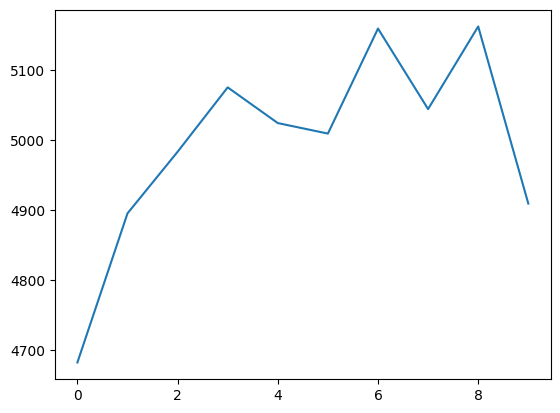

In [13]:
plt.title("Reward by Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(ending_ep_rewards)
plt.show()